In [17]:
#autoreload 
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
import torch
import lightning as lt
import yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from models import AE
model = AE()
input = torch.randn(1, 16, 32, 32)  # Example input tensor
model.test_latent_shape(input)

Input shape: torch.Size([1, 16, 32, 32])
Latent shape: torch.Size([1, 64, 4, 4])
Flattened latent shape: torch.Size([1, 1024])
Output shape: torch.Size([1, 16, 32, 32])


In [3]:
from ml.inklabel_dataset import InkLabelDataset
segment_ids = yaml.safe_load(open('../configs/segment_ids.yaml', 'r'))
print(segment_ids['segment_ids'])
segments = [segment_ids['segment_ids']['segments'][0]]
SAMPLE_SIZE = 32
dataset = InkLabelDataset(segment_ids=segments,sample_size=SAMPLE_SIZE)
train, test, val = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
train_Loader = torch.utils.data.DataLoader(train, batch_size=16, shuffle=True,num_workers=27)
test_Loader = torch.utils.data.DataLoader(test, batch_size=4, shuffle=False,num_workers=27)
validation_Loader = torch.utils.data.DataLoader(val, batch_size=4, shuffle=False,num_workers=27)

{'segments': ['20231210121321', '20231106155350', '20231005123336', '20230820203112', '20230620230619', '20230826170124', '20230702185753', '20230522215721', '20230531193658', '20230520175435', '20230903193206', '20230902141231', '20231007101615', '20230929220924', 'recto', 'verso', '20231016151000', '20231012184423', '20231031143850']}
Creating InkLabelDataset with 1 segments...
Found 1 data points for 1 provided segments.
Created 7264 samples from ink label with shapes (15872, 12544), (16, 15839, 12489) for segment 20231210121321
Created 7264 samples from ink labels.


In [32]:
trainer = lt.Trainer(max_epochs=500, accelerator="gpu", devices=1, callbacks=[lt.pytorch.callbacks.early_stopping.EarlyStopping(monitor="train_loss", patience=15, mode="min")])


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [33]:
trainer.fit(model, train_dataloaders=train_Loader, val_dataloaders=validation_Loader)
trainer.test(model, dataloaders=test_Loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name      | Type          | Params | Mode 
----------------------------------------------------
0 | encoder   | Sequential    | 83.7 K | train
1 | attention | SelfAttention | 25.2 K | train
2 | decoder   | Sequential    | 58.4 K | train
3 | criterion | MSELoss       | 0      | train
----------------------------------------------------
167 K     Trainable params
0         Non-trainable params
167 K     Total params
0.669     Total estimated model params size (MB)
68        Modules in train mode
0         Modules in eval mode


Epoch 56: 100%|██████████| 364/364 [00:05<00:00, 63.11it/s, v_num=24]       


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 182/182 [00:00<00:00, 394.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.111795574426651
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.111795574426651}]

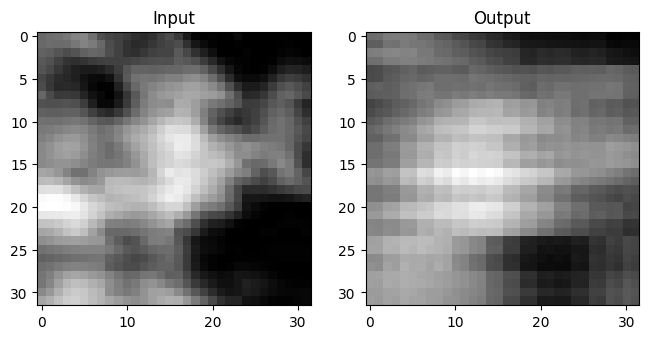

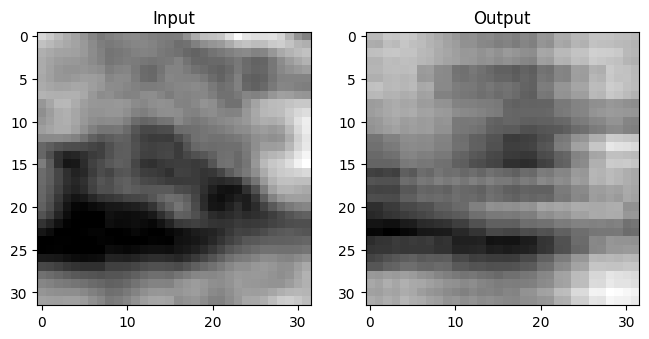

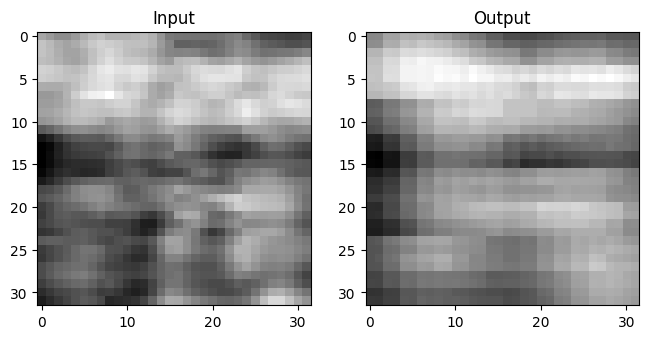

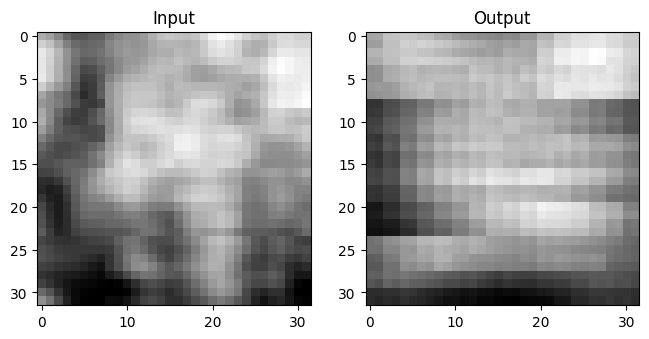

In [34]:
#print a example of the model output
import matplotlib.pyplot as plt

for batch in test_Loader:
    for idx in range(4):
        x = batch['scroll_segment'][idx]
        x = x.unsqueeze(0)  # Add batch dimension
       #x = x.unsqueeze(0)  # Add batch dimension
        #normalize the input
        x = (x - x.min()) / (x.max() - x.min())
        output = model(x)
        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title('Input')
        plt.imshow(x.squeeze()[0].cpu().numpy(), cmap='gray')
        
        plt.subplot(1, 3, 2)
        plt.title('Output')
        plt.imshow(output[0, 0].cpu().detach().numpy(), cmap='gray')
        
        plt.show()
    break

In [36]:
test = model.attention(model.encoder(x))
print(test.shape)
print(test.view(-1,128).shape)

torch.Size([1, 64, 4, 4])
torch.Size([8, 128])


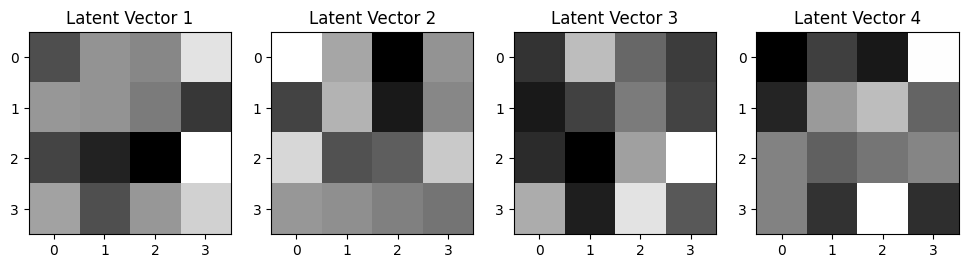

In [37]:
#show 4 latent vectors
plt.figure(figsize=(12, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f'Latent Vector {i + 1}')
    plt.imshow(test.squeeze(0)[i+3].cpu().detach().numpy(), cmap='gray')

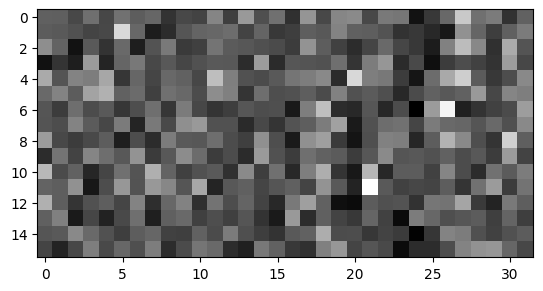

In [38]:
plt.imshow(test.view(-1,16,32)[0].cpu().detach().numpy(), cmap='gray')
plt.show()

In [39]:
#save the model to a file
import os
if not os.path.exists('encoder_ckpt'):
    os.makedirs('encoder_ckpt')
torch.save(model.encoder.state_dict(), 'encoder_ckpt/encoder.pth')
torch.save(model.attention.state_dict(), 'encoder_ckpt/attention.pth')
